<a href="https://colab.research.google.com/github/rozim/ChessGanData/blob/master/v4c_Chess_DCGAN_This_position_does_not_exist_20200828.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.tensorflow.org/tutorials/generative/dcgan


tbd: leaky relu alpha=0.2

tbd: init range of image -1..+1

tbd: weight init sd 0.02

tbd: 2015: "Adam learning rate of 0.0002 and a momentum (beta1) of 0.5"

20200828 - v2: works sort of, has mode collapse, but the output is fuzzy boards

20200828 - v3: soft labels, 0.1 / 0.9

20200828 - v4: spreadout regularizer



In [1]:
!pip3 install -q imageio
!pip3 install -q python-chess
!pip3 install -q CairoSVG==2.1.3
!pip3 install -q "tqdm>=4.36.1"


     |████████████████████████████████| 102kB 3.7MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
     |████████████████████████████████| 71kB 7.3MB/s 


In [2]:
! if [ ! -e twic1346.pgn ]; then (wget  https://theweekinchess.com/zips/twic1346g.zip && unzip twic*.zip && rm twic*.zip && echo PGN downloaded )  fi
! if [ ! -e twic1345.pgn ]; then (wget  https://theweekinchess.com/zips/twic1345g.zip && unzip twic*.zip && rm twic*.zip && echo PGN downloaded )  fi
! if [ ! -e twic1344.pgn ]; then (wget  https://theweekinchess.com/zips/twic1344g.zip && unzip twic*.zip && rm twic*.zip && echo PGN downloaded )  fi

!cat twic*.pgn > all.pgn

! test -d ChessGanData || git clone https://github.com/rozim/ChessGanData.git

--2020-08-29 19:22:15--  https://theweekinchess.com/zips/twic1346g.zip
Resolving theweekinchess.com (theweekinchess.com)... 50.87.227.133
Connecting to theweekinchess.com (theweekinchess.com)|50.87.227.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1406588 (1.3M) [application/zip]
Saving to: ‘twic1346g.zip’

twic1346g.zip       100%[===================>]   1.34M  5.38MB/s    in 0.2s    

2020-08-29 19:22:15 (5.38 MB/s) - ‘twic1346g.zip’ saved [1406588/1406588]

Archive:  twic1346g.zip
  inflating: twic1346.pgn            
PGN downloaded
--2020-08-29 19:22:16--  https://theweekinchess.com/zips/twic1345g.zip
Resolving theweekinchess.com (theweekinchess.com)... 50.87.227.133
Connecting to theweekinchess.com (theweekinchess.com)|50.87.227.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1587507 (1.5M) [application/zip]
Saving to: ‘twic1345g.zip’

twic1345g.zip       100%[===================>]   1.51M  7.26MB/s    in 0.2s    

2020

In [3]:
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import chess
import chess.svg
import chess.pgn
import cairosvg
import IPython
import random
import io #  BytesIO
import time
import itertools
import tqdm

from IPython import display

NUM_INPUT = None # set later
NUM_BATCHES = None

tf.__version__

'2.3.0'

In [4]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

BUFFER_SIZE = 60000
BATCH_SIZE = 256

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

LABEL_SMOOTHING = True

D_DROPOUT = 0.5
D_BATCHNORM = False

SPREADOUT = 0.9

In [5]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()


11493376/11490434 [==============================] - 0s 0us/step


In [6]:
print(type(train_images[0]))
print(type(train_images))

print(train_images[0].shape)
print(train_images.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(28, 28)
(60000, 28, 28)


<class 'bytes'>


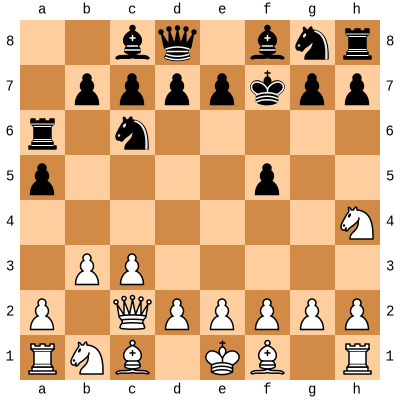

In [7]:
b = chess.Board()
for _ in range(10):
  legal = list(b.legal_moves)
  if len(legal) == 0:
    print('no legal moves!')
    break
  b.push(random.choice(legal))
png = cairosvg.svg2png(bytestring=chess.svg.board(b))
print(type(png))
open('foo.png', 'wb').write(png)
IPython.display.Image(data=png)

In [8]:
def file_to_numpy(fn):
  return np.array(PIL.Image.open(fn).resize((128, 128)))


def file_to_gray_numpy(fn):
  return np.array(PIL.Image.open(fn).convert('L').resize((128, 128)))


def numpy_to_pil(ar):
  return PIL.Image.fromarray(ar)


def pil_to_bytes(img):
  b = io.BytesIO()
  img.save(b, format='png')
  return b.getvalue()


def numpy_to_bytes(ar):
  return pil_to_bytes(numpy_to_pil(ar))


def parse_games(fns):
  return list(itertools.chain([parse_games1(fn) for fn in fns]))
 

def parse_games1(fn):
  pgn = open(fn, encoding = "ISO-8859-1")
  while True:
    g = chess.pgn.read_game(pgn)
    if g is None:
      break
    yield g
  del pgn


def random_position(g):
  b = g.board()
  moves = list(g.main_line())
  if len(moves) <= 1:
      return None
  pick = random.randint(0, len(moves) - 1)
  for i, move in enumerate(moves):
    if i == pick:
      return b
    b.push(move)  


def board_to_png(b):
  return cairosvg.svg2png(bytestring=chess.svg.board(b))


def board_to_gray_numpy(b):
  png = board_to_png(b)
  buf = io.BytesIO()
  buf.write(png)
  #open('foo.png', 'wb').write(png)
  #return file_to_gray_numpy('foo.png')
  buf.seek(0)
  return file_to_gray_numpy(buf)


def pgn_to_unique_positions(fn, limit=None):
  already = set()
  row = 0
  mod = 1
  for i, g in enumerate(parse_games1(fn)):
    row += 1
    if row % mod == 0:
      print('row: ', row)
      mod *= 2
      if mod > 512:
        mod = 512
    b = random_position(g)
    if b is None:
      continue
    fen = b.fen()
    simple = fen.split(' ')[0]
    if simple in already:
      continue
    yield board_to_gray_numpy(b)
    if limit is not None and i >= limit:
      break


def generate_training_data():
  foo, mod = -1, 1
  while True:
    foo += 1
    if foo % mod == 0:
      print(foo)
      mod *= 2
      if mod > 4096:
        mod = 4096
    try:
      yield np.load('ChessGanData/128_gray/{:06d}.npz'.format(foo))['arr_0']
    except FileNotFoundError:
      break
      

In [9]:
# https://arxiv.org/pdf/1708.06320.pdf
def spreadout_regularizer(embeddings, normalized_input=False):
  """Provides regularization loss to encourage spread out embeddings.                                                                                                                        
                                                                                                                                                                                             
  Args:                                                                                                                                                                                      
    embeddings: The embeddings to regularize.                                                                                                                                                
    normalized_input: Whether the embeddings are already normalized. If `False`,                                                                                                             
      this op will normalize the embeddings before applying the regularization                                                                                                               
      loss. Setting to `True` will save some computation.                                                                                                                                    
                                                                                                                                                                                             
  Returns:                                                                                                                                                                                   
    The computed spreadout regularization loss.                                                                                                                                              
  """
  with tf.name_scope('spreadout_regularizer'):
    if not normalized_input:
      embeddings = tf.nn.l2_normalize(embeddings, axis=1)

    num_embeddings = tf.shape(embeddings)[0]
    gram_matrix = tf.matmul(embeddings, embeddings, transpose_b=True)
    gram_matrix = tf.linalg.set_diag(gram_matrix, tf.zeros(num_embeddings))

    loss = tf.reduce_sum(tf.square(gram_matrix))
    loss /= tf.cast(num_embeddings * (num_embeddings - 1), tf.dtypes.float32)
    return loss



In [10]:
# Read training data
t1 = time.time()
train_images = np.stack(list(generate_training_data()))

print(type(train_images))
print(train_images.shape)
print('elapsed: {:.1f}'.format(time.time() - t1))

NUM_IMAGES = train_images.shape[0]
NUM_BATCHES = NUM_IMAGES // BATCH_SIZE

print(NUM_IMAGES, NUM_BATCHES)


0
2
4
8
16
32
64
128
256
512
1024
2048
4096
8192
12288
16384
20480
24576
28672
32768
<class 'numpy.ndarray'>
(35255, 128, 128)
elapsed: 19.9
35255 137


In [11]:
# Prepare input pipeline

train_images = train_images.reshape(train_images.shape[0], 128, 128, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
def make_generator_model():
    # dcgan, from Ian's paper: https://arxiv.org/pdf/1701.00160.pdf
    # 4, 4, 1024
    # 8, 8, 512 (stride=2, kernel=5,5)
    # 16, 16, 256 (=2)
    # 32, 32, 128 (=2)
    # 64, 64, 3 <-- final
    #
    model = tf.keras.Sequential()

    model.add(layers.Dense(4 * 4 * 1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 1024)))

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 1), model.output_shape

    return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 512)         13107200  
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 512)         0

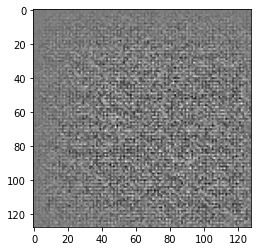

In [13]:
generator = make_generator_model()
generator.summary()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

print('gen image: ', generated_image.shape)
print('gen image[...]: ', generated_image[0, :, :, 0].shape)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')



In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(D_DROPOUT))
    if D_BATCHNORM:
      model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(D_DROPOUT))
    if D_BATCHNORM:
      model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [15]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print(decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1664      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       204928    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)           

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

def discriminator_loss(real_output, fake_output):
  if LABEL_SMOOTHING:
    real_loss = cross_entropy(0.9 * tf.ones_like(real_output, dtype=tf.float32), real_output)
    fake_loss = cross_entropy(0.1 * tf.ones_like(fake_output, dtype=tf.float32), fake_output)
  else:
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)

  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [17]:

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [18]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      #flat_generated_images = tf.reshape(generated_images, shape=(128 * 128))
      layer = layers.Flatten(data_format='channels_last')
      flat_generated_images = layer.apply(generated_images)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      spread_loss = spreadout_regularizer(flat_generated_images)
      gen_loss = (1.0 - SPREADOUT) * generator_loss(fake_output) + (SPREADOUT * spread_loss)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return (gen_loss, disc_loss, spread_loss)

In [19]:
def train(dataset, epochs):
  g_loss_all, d_loss_all, s_loss_all = [], [], []
  #pbar1 = tqdm.tqdm(epochs)
  for epoch in range(epochs):
    #pbar1.update()
    start = time.time()
    g_loss_avg = tf.keras.metrics.Mean()
    d_loss_avg = tf.keras.metrics.Mean()
    s_loss_avg = tf.keras.metrics.Mean()

    #pbar2 = tqdm.tqdm(NUM_BATCHES)
    for i, image_batch in enumerate(dataset):
      #pbar2.update()
      (g_loss, d_loss, s_loss) = train_step(image_batch)
      g_loss_avg.update_state(g_loss)
      d_loss_avg.update_state(d_loss)
      s_loss_avg.update_state(s_loss)

      if i % 25 == 0:
        print('{}. {:.0f}% {:.1f}s : {:.4f} : {:.4f} : {:.4f}'.format(i, (100.0 *i) / NUM_BATCHES, time.time() - start, 
                                                             g_loss_avg.result(), 
                                                             d_loss_avg.result(),
                                                             s_loss_avg.result()))
    g_loss_all.append(g_loss_avg.result().numpy())
    d_loss_all.append(d_loss_avg.result().numpy())
    s_loss_all.append(s_loss_avg.result().numpy())

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    if (epoch + 1) % 25 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {}/{} is {} sec'.format(epoch + 1, EPOCHS, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  checkpoint.save(file_prefix = checkpoint_prefix)

  return (g_loss_all, d_loss_all, s_loss_all)

In [20]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(12,12))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
(g_loss_all, d_loss_all, s_loss_all) = train(train_dataset, EPOCHS)
print('all done')

Instructions for updating:
Please use `layer.__call__` method instead.
0. 0% 7.8s : 0.2402 : 1.4103 : 0.1924
25. 18% 30.6s : 0.1837 : 0.8410 : 0.0591
50. 36% 54.0s : 0.2592 : 0.7682 : 0.1152


In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

print('gen image: ', generated_image.shape)
print('gen image[...]: ', generated_image[0, :, :, 0].shape)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [ ]:
d_loss_all

In [ ]:
foo = 0
t1 = time.time()
while True:
  try:
    ar = np.load('ChessGan/128_gray/{:06d}.npz'.format(foo))['arr_0']
  except FileNotFoundError:
    break
  foo += 1
  if foo < 2:
    print(ar.shape)
print('done', time.time() - t1, foo)